In [2]:
import cdsapi
import xarray as xr
import pygrib
import numpy as np
import pandas as pd

import requests
import os
import xarray as xr
import timezonefinder

In [ ]:
#What a permaculture project need to know when they start

In [3]:
import time
from geopy.geocoders import Nominatim

# select the years you want to download:
start_year = 1992
end_year = 2022
year_range = [i for i in range(start_year, end_year + 1)]
print(year_range)

# Use geopy to get the latitude and longitude of the city
geolocator = Nominatim(user_agent="permaculture-climate")
location = geolocator.geocode("Puebla de don Fadrique, Spain")
# Add a delay between requests
time.sleep(1)

c = cdsapi.Client()
try:
    data = c.retrieve("reanalysis-era5-single-levels-monthly-means",
    {"format": "grib",
     "product_type": "monthly_averaged_reanalysis_by_hour_of_day",
     "variable": ['10m_u_component_of_wind', '10m_v_component_of_wind', 
                '2m_temperature',
                'snowfall', 
                'soil_temperature_level_1', 
                'soil_type',
                'total_cloud_cover', 
                'total_precipitation',
                ],
    "area": [location.latitude + 1, 
             location.longitude - 1, 
             location.latitude - 1, 
             location.longitude + 1],  # North, West, South, East. 
    "year": year_range,
    "month": ['01', '02', '03',
           '04', '05', '06',
           '07', '08', '09',
           '10', '11', '12'],
    "time": ["00:00","01:00","02:00","03:00","04:00","05:00",
             "06:00","07:00","08:00","09:00","10:00","11:00",
             "12:00", "13:00","14:00","15:00","16:00","17:00",
             "18:00","19:00","20:00","21:00","22:00","23:00"]
    })

    # Get the location of the file to download
    url = data.location

    # Download the file
    response = requests.get(url)

    # Check if the request was successful
    response.raise_for_status()

except requests.exceptions.HTTPError as errh:
    print ("HTTP Error:",errh)
except requests.exceptions.ConnectionError as errc:
    print ("Error Connecting:",errc)
except requests.exceptions.Timeout as errt:
    print ("Timeout Error:",errt)
except requests.exceptions.RequestException as err:
    print ("Something went wrong with the request:",err)

else:
    # If the request was successful, write the file
    filename = 'download.grib'
    with open(filename, 'wb') as f:
        f.write(response.content)

    # Print the location where the file is saved
    print(f"File saved at: {os.path.abspath(filename)}")

[1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


2023-12-13 10:28:30,291 INFO Welcome to the CDS
2023-12-13 10:28:30,291 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-12-13 10:28:30,498 INFO Request is queued


KeyboardInterrupt: 

In [ ]:
#temperatura durante l'anno 
#precipitaciones durante l'anno
#vento durante l'anno (rosa dei venti)
#x axisx: month name, tilted, on the 15th of each month, plotly express theme "simple_white"

In [4]:
# List of variables to load

# List of variables to load
variables = ['2t','10v','10u','tp','tcc']

# Dictionary to hold the datasets
datasets = {}

# Open the GRIB file for each variable
for var in variables:
    ds = xr.open_dataset('download.grib', engine='cfgrib', backend_kwargs={'filter_by_keys': {'shortName': var}})
    datasets[var] = ds

# Print the datasets
for var, ds in datasets.items():
    print(f"{var}:")
    print(ds)
    print("\n")

2t:
<xarray.Dataset>
Dimensions:     (time: 8928, latitude: 9, longitude: 9)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1992-01-01 ... 2022-12-01T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 38.96 38.71 38.46 38.21 ... 37.46 37.21 36.96
  * longitude   (longitude) float64 -3.435 -3.185 -2.935 ... -1.934 -1.684 358.6
    valid_time  (time) datetime64[ns] ...
Data variables:
    t2m         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-12-13T10:29 GRIB to CDM+CF via cfgrib-0.9.1...


10v:
<xarray.Dataset>
Dimensions:     (time: 8928, latitude: 9, longitude: 9)
Coordi

In [5]:
# Calculate the climatology and average over latitude and longitude

avg_tp = datasets['tp']['tp'].groupby('time.month').mean(['time', 'latitude', 'longitude', 'step'])*1000
avg_temp = datasets['2t']['t2m'].groupby('time.month').mean(['time', 'latitude', 'longitude'])-273.15
max_temp = datasets['2t']['t2m'].groupby('time.month').max(['time', 'latitude', 'longitude'])-273.15
min_temp = datasets['2t']['t2m'].groupby('time.month').min(['time', 'latitude', 'longitude'])-273.15


#check the dimensions of the data
print(avg_temp.dims)
print(avg_tp.dims)


('month',)
('month',)


In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot with shared x-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add a bar chart for precipitation to the secondary y-axis
fig.add_trace(
    go.Bar(x=avg_tp.month, y=avg_tp, name='Precipitation', opacity=0.5),
    secondary_y=False,
)

# Add a line chart for temperature to the primary y-axis
fig.add_trace(
    go.Scatter(x=avg_temp.month, y=avg_temp, mode='lines', name='Temperature'),
    secondary_y=True,
)

# Set the layout to have two y-axes
fig.update_layout(
    title = 'Average Temperature and Precipitation',
    yaxis=dict(title='Precipitation (mm)'),
    yaxis2=dict(title='Temperature (°C)', overlaying='y', side='right'),
    xaxis=dict(
        title='Month',
        tickmode='array',
        tickvals=avg_temp.month,
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        tickangle=-45
    ),
    template='simple_white'
)

# Show the figure
fig.show()

In [13]:
### example figure with show/hide traces
from plotly.subplots import make_subplots

# Create a subplot with shared x-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add a bar chart for precipitation to the secondary y-axis
fig.add_trace(
    go.Bar(x=avg_tp.month, y=avg_tp, name='Precipitation', opacity=0.5),
    secondary_y=False,
)

# Add a line chart for temperature to the primary y-axis
fig.add_trace(
    go.Scatter(x=avg_temp.month, y=avg_temp, mode='lines', name='Temperature'),
    secondary_y=True,
)

# Add another line chart for a new data series
fig.add_trace(
    go.Scatter(x=avg_temp.month, y=avg_temp, mode='lines', name='New Data'),
    secondary_y=True,
)

# Set the layout to have two y-axes
fig.update_layout(
    title = 'Average Temperature and Precipitation',
    yaxis=dict(title='Precipitation (mm)'),
    yaxis2=dict(title='Temperature (°C)', overlaying='y', side='right'),
    xaxis=dict(
        title='Month',
        tickmode='array',
        tickvals=avg_temp.month,
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        tickangle=-45
    ),
    template='simple_white',
)

# Show the figure
fig.show()

In [45]:
#do do: revisit the title
import plotly.express as px
import plotly
print(plotly.__version__)

# Create a DataFrame from the DataArrays
df = pd.DataFrame({
    'month': avg_temp.month.values,
    'avg_temp': avg_temp.values,
    'max_temp': max_temp.values,
    'min_temp': min_temp.values
})

# Create a line chart for average temperature

fig = go.Figure()

fig.add_trace(go.Scatter(x=df['month'], y=df['avg_temp'], mode='lines', name='Max Temperature', line_color='orange'))

# Add a line chart for max temperature
fig.add_trace(go.Scatter(x=df['month'], y=df['max_temp'], mode='lines', name='Average Temperature', line_color='red'))

# Add a line chart for min temperature
fig.add_trace(go.Scatter(x=df['month'], y=df['min_temp'], mode='lines', name='Min Temperature', line_color='red', fill='tonexty', fillcolor = 'rgba(255, 0, 0, 0.1)'))

# Add a line chart for min temperature
fig.add_hline(y=0, opacity=1, line_width=2, line_dash='dash', line_color='blue', annotation_text='freezing', annotation_position='top')

# Set the layout
fig.update_layout(
    yaxis=dict(title='Temperature (°C)'),
    xaxis=dict(
        title='Month',
        tickmode='array',
        tickvals=df['month'],
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        tickangle=-45
    ),
    template='simple_white'
)
# Show the figure
fig.show()

5.18.0


In [ ]:
avg_u = datasets['10u']['u10'].groupby('time.month').mean(['latitude', 'longitude'])
avg_v = datasets['10v']['v10'].groupby('time.month').mean(['latitude', 'longitude'])

In [99]:
import numpy as np

# Calculate wind speed
wind_speed = np.sqrt(avg_u**2 + avg_v**2)
#convert to km/h
wind_speed = wind_speed*3.6

# Calculate wind direction (see: https://confluence.ecmwf.int/pages/viewpage.action?pageId=133262398)
wind_direction = np.mod(180 + np.arctan2(avg_u, avg_v) * (180 / np.pi), 360)

# Print the wind speed and direction
print("Wind Speed:")
print(wind_speed)
print("\n")
print("Wind Direction:")
print(wind_direction)


Wind Speed:
<xarray.DataArray (time: 8928)>
array([2.7199543, 2.6942606, 2.8063412, ..., 5.2000647, 5.3631635,
       5.258852 ], dtype=float32)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 1992-01-01 ... 2022-12-01T23:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    valid_time  (time) datetime64[ns] 1992-01-01 ... 2022-12-01T23:00:00


Wind Direction:
<xarray.DataArray 'u10' (time: 8928)>
array([ 42.73532,  38.98648,  36.48271, ..., 246.88597, 248.185  ,
       250.73   ], dtype=float32)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 1992-01-01 ... 2022-12-01T23:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    valid_time  (time) datetime64[ns] 1992-01-01 ... 2022-12-01T23:00:00


In [87]:
#prepare the data for the wind rose
import pandas as pd

df = pd.DataFrame({'speed': wind_speed, 'direction': wind_direction})

df['direction'] = pd.cut(df['direction'], bins=np.linspace(0, 360, 9), labels=["N", "NE", "E", "SE", "S", "SW", "W", "NW"])
df['speed'] = pd.cut(df['speed'], bins=np.arange(0, df['speed'].max() + 1.1, 2))

# Calculate frequencies
frequency_df = df.groupby(['direction', 'speed']).size().reset_index(name='frequency')

# Calculate total frequency
total_frequency = frequency_df['frequency'].sum()

# Convert frequency to proportion
frequency_df['frequency'] = frequency_df['frequency'] / total_frequency
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

# Get the number of unique 'speed' categories
num_categories = len(frequency_df['speed'].unique())

# Sort the 'speed' categories
sorted_categories = frequency_df['speed'].sort_values().unique()

# Create a custom color scale with the same number of colors as there are categories
custom_color_scale = plt.cm.viridis_r(np.linspace(0, 1, num_categories))

# Convert the color scale to a list of hex color strings
custom_color_scale = [matplotlib.colors.rgb2hex(color) for color in custom_color_scale]

# Define a color map for the sorted 'speed' categories
color_map = {category: color for category, color in zip(sorted_categories, custom_color_scale)}

# Create the wind rose chart
fig = px.bar_polar(frequency_df, 
                   r='frequency', 
                   theta='direction', 
                   color='speed', 
                   template='simple_white', 
                   color_discrete_map=color_map, labels={"speed": "Speed [km/h]"})  # Use the color map

# Update the layout to make it rectangular
fig.update_layout(
    width=800,  # Set the width to 700 pixels
    height=600,  # Set the height to 1000 pixels
    polar_radialaxis_showgrid=True,  # Show radial grid
    polar_angularaxis_showgrid=True  # Show angular grid
)

fig.show()


/var/folders/65/jjhht_kn6479d_8drvxjcgjh0000gn/T/ipykernel_9715/1287714439.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/giacomo/.pyenv/versions/3.9.7/envs/climate_permaculture/lib/python3.9/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
# Calculate the temperature difference
temp_diff = max_temp - min_temp

# Create a Plotly figure
fig = go.Figure()

# Add a line chart for temperature difference
fig.add_trace(go.Scatter(
    x=temp_diff.month,
    y=temp_diff,
    mode='lines',
    name='Temperature Difference'
))

# Set the layout
fig.update_layout(
    xaxis=dict(title='Month'),
    yaxis=dict(title='Temperature Difference (°C)'),
    title='Temperature Difference Data'
)

# Show the figure
fig.show()

In [ ]:
# Create a Plotly figure
fig = go.Figure()

# Add a bar chart for min-max temperature
fig.add_trace(go.Bar(
    x=min_temp.month,
    y=max_temp - min_temp,
    base=min_temp,
    name='Min-Max Temperature'
))

# Set the layout
fig.update_layout(
    xaxis=dict(title='Month'),
    yaxis=dict(title='Temperature (°C)'),
    title='Min-Max Temperature Data'
)

# Show the figure
fig.show()

In [ ]:
# Subtract the average temperature from min and max temperatures
min_temp_adj = min_temp - avg_temp
max_temp_adj = max_temp - avg_temp

# Create a Plotly figure
fig = go.Figure()

# Add a bar chart for adjusted min-max temperature
fig.add_trace(go.Bar(
    x=min_temp_adj.month,
    y=max_temp_adj - min_temp_adj,
    base=min_temp_adj,
    name='Adjusted Min-Max Temperature'
))

# Set the layout
fig.update_layout(
    xaxis=dict(title='Month'),
    yaxis=dict(title='Temperature Difference from Average (°C)'),
    title='Adjusted Min-Max Temperature Data'
)

# Show the figure
fig.show()

In [107]:

#HERE EXTRRACT CLOUD COVER VALUES

c = cdsapi.Client()
try:
    data = c.retrieve("reanalysis-era5-single-levels-monthly-means",
    {"format": "grib",
     "product_type": "monthly_averaged_reanalysis_by_hour_of_day",
     "variable": ['total_cloud_cover', 
                ],
    "area": [location.latitude + 1, 
             location.longitude - 1, 
             location.latitude - 1, 
             location.longitude + 1],  # North, West, South, East. 
    "year": year_range,
    "month": ['01', '02', '03',
           '04', '05', '06',
           '07', '08', '09',
           '10', '11', '12'],
    "time": ["00:00","01:00","02:00","03:00","04:00","05:00",
             "06:00","07:00","08:00","09:00","10:00","11:00",
             "12:00", "13:00","14:00","15:00","16:00","17:00",
             "18:00","19:00","20:00","21:00","22:00","23:00"]
    })

    # Get the location of the file to download
    url = data.location

    # Download the file
    response = requests.get(url)

    # Check if the request was successful
    response.raise_for_status()

except requests.exceptions.HTTPError as errh:
    print ("HTTP Error:",errh)
except requests.exceptions.ConnectionError as errc:
    print ("Error Connecting:",errc)
except requests.exceptions.Timeout as errt:
    print ("Timeout Error:",errt)
except requests.exceptions.RequestException as err:
    print ("Something went wrong with the request:",err)

else:
    # If the request was successful, write the file
    filename = 'download_cloud_data.grib'
    with open(filename, 'wb') as f:
        f.write(response.content)

    # Print the location where the file is saved
    print(f"File saved at: {os.path.abspath(filename)}")

2023-11-27 17:12:53,613 INFO Welcome to the CDS
2023-11-27 17:12:53,617 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-11-27 17:12:53,808 INFO Request is completed


File saved at: c:\Users\matthias\Documents\Projects\permaculture-climate\download_cloud_data.grib


In [3]:
# Open the GRIB file
import pygrib

# Open the GRIB file
grbs = pygrib.open('download_cloud_data.grib')

# Read the names of the variables
variable_names_clouds = [grb.name for grb in grbs]

# Convert the set to a list
unique_variable_names_clouds = list(set(variable_names_clouds))

# Print the variable names
print(unique_variable_names_clouds)

['Total cloud cover']


In [3]:
import xarray as xr

# List of variables to load


# Dictionary to hold the datasets
datasets_clouds = {}

# Open the GRIB file for each variable
ds_c = xr.open_dataset('download_cloud_data.grib', engine='cfgrib')
#datasets_clouds[var] = ds_c

# Print the datasets
for var, ds in ds_c.items():
    print(f"{ds_c}:")
    print(ds_c)
    print("\n")

Ignoring index file 'download_cloud_data.grib.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:     (time: 8928, latitude: 9, longitude: 9)
Coordinates:
    number      int32 ...
  * time        (time) datetime64[ns] 1992-01-01 ... 2022-12-01T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 38.96 38.71 38.46 38.21 ... 37.46 37.21 36.96
  * longitude   (longitude) float64 -3.435 -3.185 -2.935 ... -1.934 -1.684 358.6
    valid_time  (time) datetime64[ns] ...
Data variables:
    tcc         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-12-01T12:26 GRIB to CDM+CF via cfgrib-0.9.1...:
<xarray.Dataset>
Dimensions:     (time: 8928, latitude: 9, longitude: 9)
Coordinates:
   

In [78]:
#Get rid of the latitude and longitude dimensions by averaging the data
avg_tcc = ds['tcc'].mean(dim=['longitude', 'latitude'])

#Now average the data of each hour of each month across the 30 years of data. We end up with 288 data points, representing 24 h per month
month_hour_grouped = avg_tcc.groupby(avg_tcc['time.month'] * 100 + avg_tcc['time.hour'])
hourly_mean_by_month = month_hour_grouped.mean(dim='time')

print(avg_tcc)

<xarray.DataArray 'tcc' (time: 8928)>
array([0.7640059 , 0.7665434 , 0.76574665, ..., 0.81035256, 0.8215949 ,
       0.819704  ], dtype=float32)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1992-01-01 ... 2022-12-01T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
    valid_time  (time) datetime64[ns] ...


In [83]:
from datetime import datetime
import timezonefinder


#find the timezone of the location
tf = timezonefinder.TimezoneFinder()
timezone_str = tf.certain_timezone_at(lat=location.latitude, lng=location.longitude)

#define location infos for the astral package
location_info = LocationInfo(None, None, timezone_str, location.latitude, location.longitude)

#define two empty lists for sunrise and sunset times
sunrise_times, sunset_times = [], []

# append sunrise and sunset times for the 15th of every month of 2022
for month in range(1, 13):
    date = datetime(2022, month, 15)
    
    s = sun(location_info.observer, date=date, tzinfo=timezone_str)
    sunrise_times.append(s['sunrise'].strftime('%H:%M'))
    sunset_times.append(s['sunset'].strftime('%H:%M'))

print(sunrise_times, sunset_times)
    

NameError: name 'location' is not defined

In [6]:
# Create a graph with cloud cover values plus sunrise and sunset times

# Get rid of the coding of the month/hour combination used for grouping before. 
month_values = hourly_mean_by_month['group'] // 100
hour_values = hourly_mean_by_month['group'] % 100

# Reshape the data to match the format expected by Plotly
data_reshaped = hourly_mean_by_month.values.reshape((12, 24)).T  # Use -1 to automatically infer the size

fig = go.Figure()

fig.add_trace(go.Heatmap(
    z=data_reshaped,
    x=list(range(12)),
    y=list(range(24)),
    xgap = 5,
    colorscale='gray_r',
    colorbar=dict(title="Cloud Cover"),
))

# Set x-axis tickvals and ticktext for each month
fig.update_xaxes(
    tickvals=list(range(len(month_values))),
    ticktext=[f"{month_name}" for month_name in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]],
    tickmode='array',  # Use 'array' for custom tickvals and ticktext
    tickangle=-45,  # Rotate tick labels for better readability
)

# Set axis labels and title
fig.update_layout(
    title='Monthly hourly mean cloud cover with sunrise and sunset times',
    yaxis_title='Hour of the day',
    xaxis_title='Month',
)


# Set x-axis tickvals and ticktext for each day of the month


# Add a line for sunset times
fig.add_trace(go.Scatter(
    x=list(range(12)),
    y=[float('{:.2f}'.format(int(h) + int(m) / 60)) for h, m in [time.split(':') for time in sunset_times]],
    mode='lines',
    line=dict(color='rgb(150,0,255)', width=2),
    name='Sunset'
))

# Add a line for sunrise times
fig.add_trace(go.Scatter(
    x=list(range(12)),
    y=[float('{:.2f}'.format(int(h) + int(m) / 60)) for h, m in [time.split(':') for time in sunrise_times]],
    mode='lines',
    line=dict(color='rgb(255,65,0)', width=2),
    
    name='Sunrise'
))


# Update layout to show custom line in legend
fig.update_layout(
    showlegend=True,
    legend=dict(x=1.02, y=1.15),
    yaxis=dict(
        dtick=2,)
)


# Show the plot

fig.show()

### sunrise sunset times

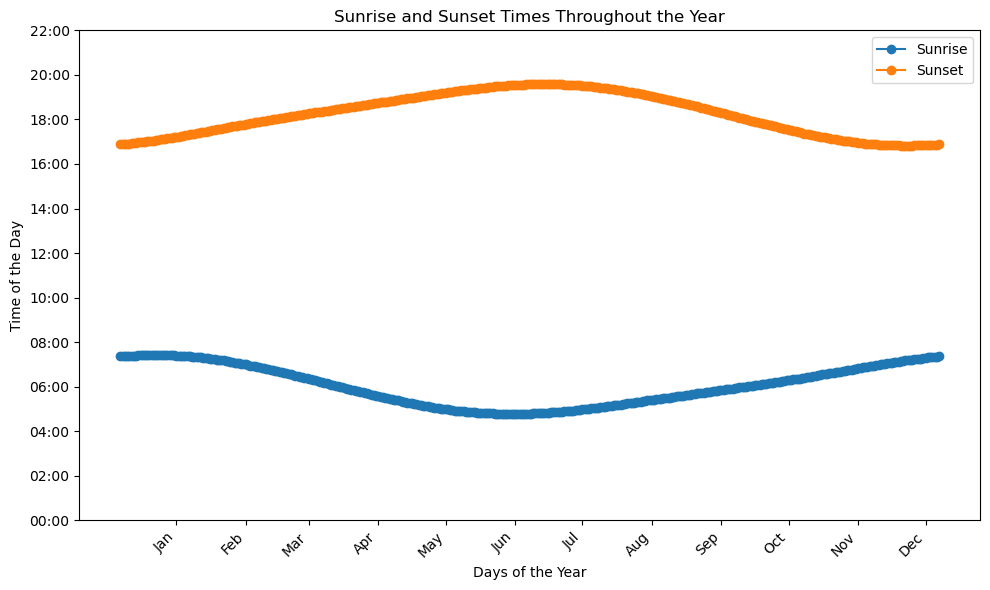

In [61]:
sunrise_times = pd.to_datetime(sunrise_times)
sunset_times = pd.to_datetime(sunset_times)

# Create a range of dates for the x-axis
dates = pd.date_range(start="2022-12-21", end="2023-12-21", freq="D")

# Create a plot
plt.figure(figsize=(10, 6))

# Plot sunrise times
plt.plot(dates, sunrise_times, label="Sunrise", marker='o')

# Plot sunset times
plt.plot(dates, sunset_times, label="Sunset", marker='o')

# Customize the x-axis ticks
first_of_month = pd.date_range(start="2023-01-01", end="2023-12-31", freq="MS")
tick_positions = [date for date in dates if date.day == 15]
tick_labels = [date.strftime("%b") for date in first_of_month]

plt.xticks(tick_positions, tick_labels)

# Customize the y-axis
plt.yticks(pd.date_range("00:00", "23:59", freq="2H"), [time.strftime("%H:%M") for time in pd.date_range("00:00", "23:59", freq="2H")])

# Set labels and title
plt.xlabel("Days of the Year")
plt.ylabel("Time of the Day")
plt.title("Sunrise and Sunset Times Throughout the Year")

# Add legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#ground freezing another plot or highlight in temperature plot

# PROJECTION DATA

In [ ]:
c = cdsapi.Client()

c.retrieve(
    'projections-cmip6',
    {
        'format': 'zip',
        'temporal_resolution': 'monthly',
        'experiment': 'ssp2_4_5',
        'variable': 'air_temperature',
        'level': '1000',
        'model': 'cmcc_esm2',
        'year': [
            '2023', '2026', '2027',
            '2029', '2030', '2033',
            '2034', '2036',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'area': [
            90, -180, -90,
            180,
        ],
    },
    'download.zip')